In [1]:
from tensorflow import keras
import os
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from readInImages import readInImages
import cv2

In [2]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure(figsize=(10,10))
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

In [3]:
model_to_load = 'final/ZFNet-map-baseline-1'

In [4]:
model = keras.models.load_model('saved_models/{}.h5'.format(model_to_load))

2022-06-14 08:18:05.848372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 08:18:05.853277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 08:18:05.853475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 08:18:05.854407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Use a distinct dataset to assess trained model's performance
* still camera trap images from same location(s), but subset was not used for training, validation, or testing
* note: images are not pre-processed, and are simply loaded in and resized
* TODO: use Australian camera trap images from different location(s) to assess performance

In [5]:
unlabelled_test_images = []
folders_dataset = next(os.walk('data/unlabelled_test_data'))[1]
folders_dataset = sorted(folders_dataset)
print('folders_dataset: {}'.format(folders_dataset))
for folder in folders_dataset:
    unlabelled_test_images = [*unlabelled_test_images, *readInImages('unlabelled_test_data', folder, False)]

unlabelled_test_images = np.stack(unlabelled_test_images, axis = 0)
print('stacked unlabelled_test_images shape: {}'.format(unlabelled_test_images.shape))

folders_dataset: ['images']
reading in images for subset: images
all_image_filenames length: 18
stacked unlabelled_test_images shape: (18, 224, 224, 3)


### Predict

In [6]:
class_mappings = ['Bird', 'Cat', 'Dog', 'Empty photo', 'Emu', 'Fox', 'Humman Presense/Deployment', 'Kangaroo', 'Other', 'Rabbit']

2022-06-14 08:18:07.304729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-06-14 08:18:07.620356: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


1/1 [==============================] - 1s 1s/step


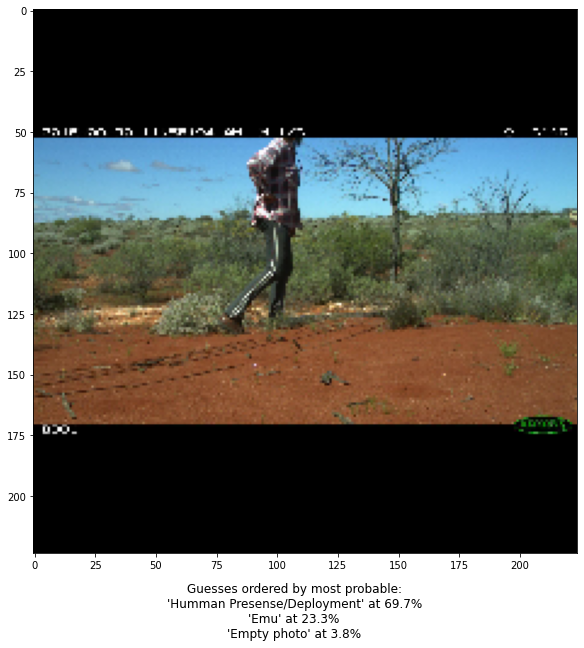

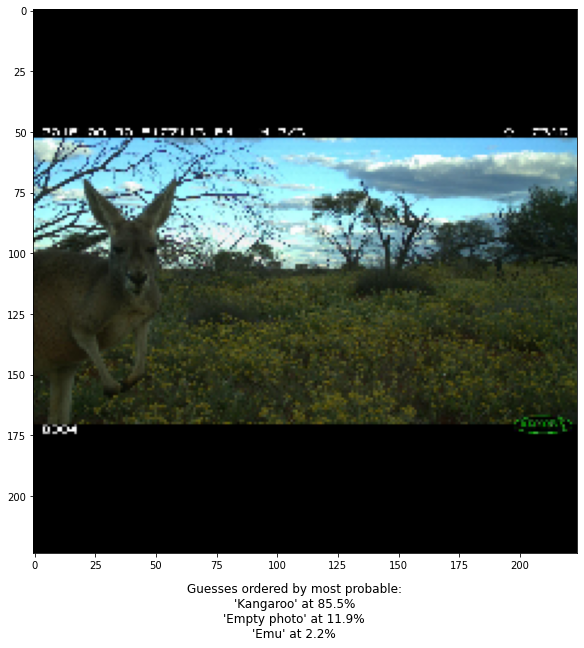

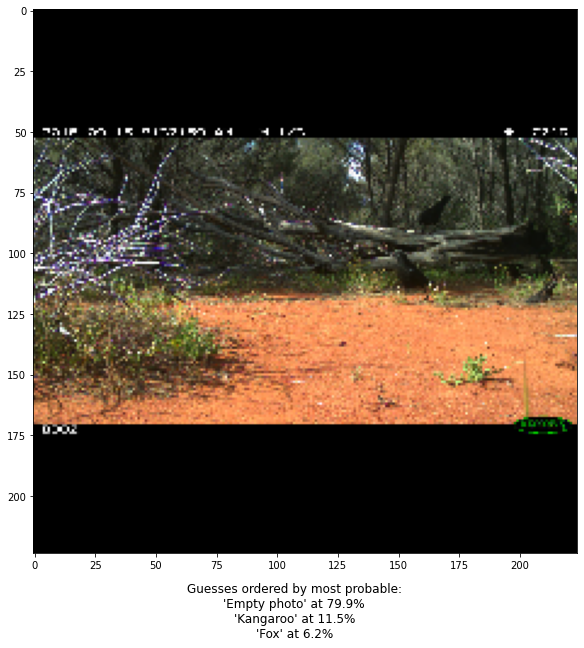

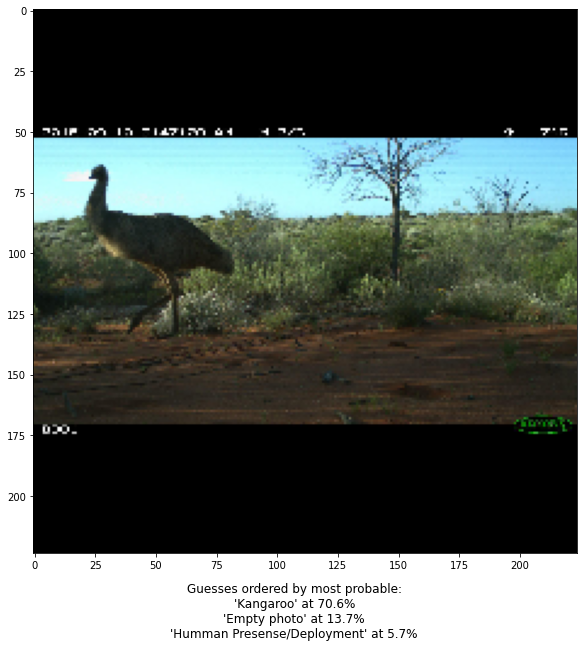

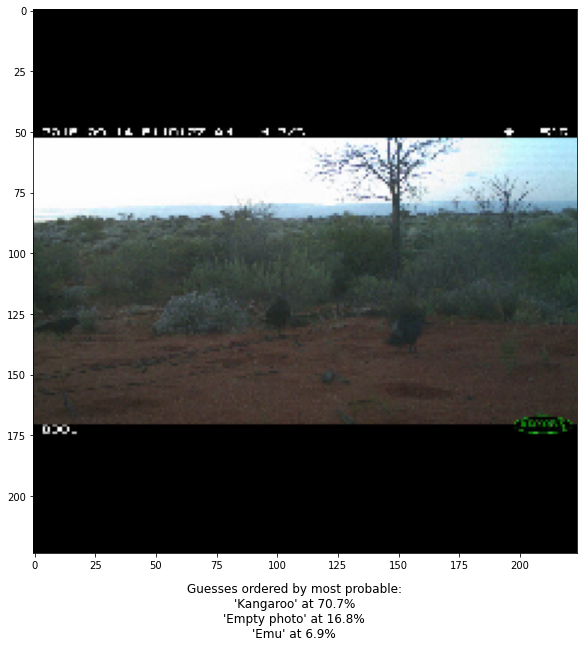

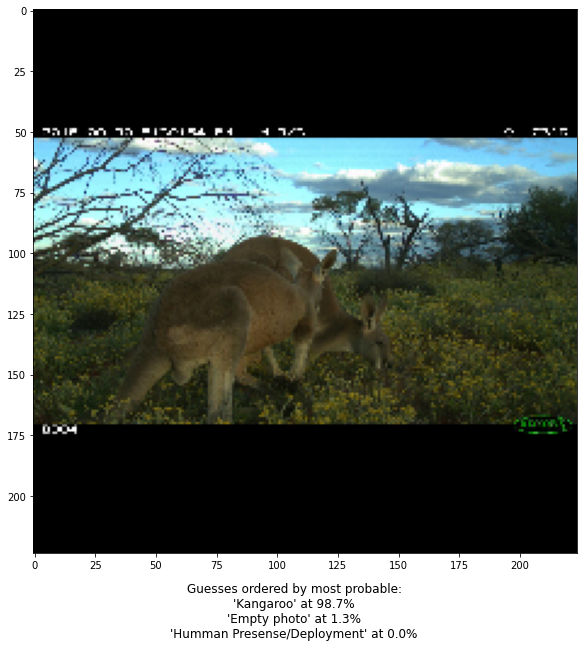

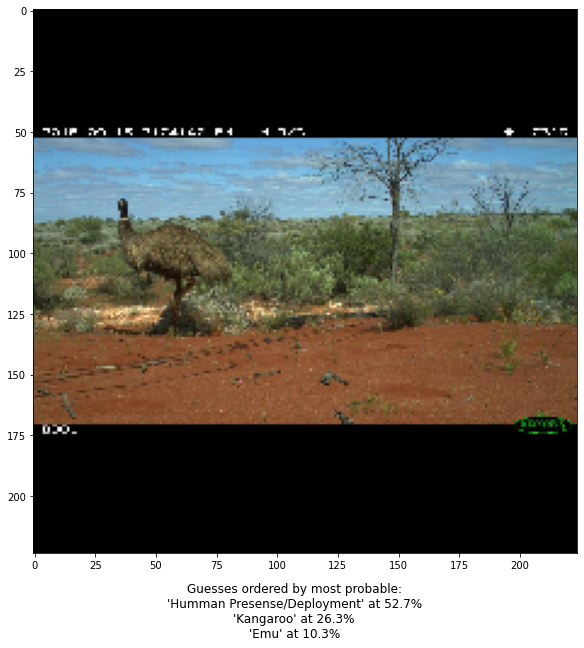

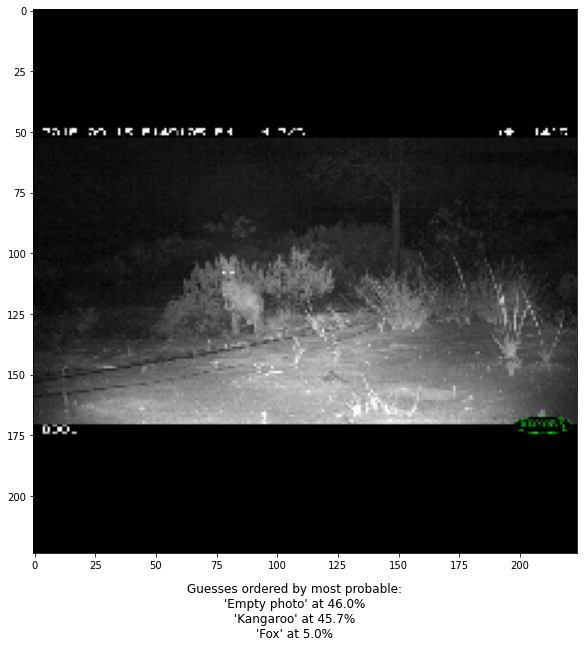

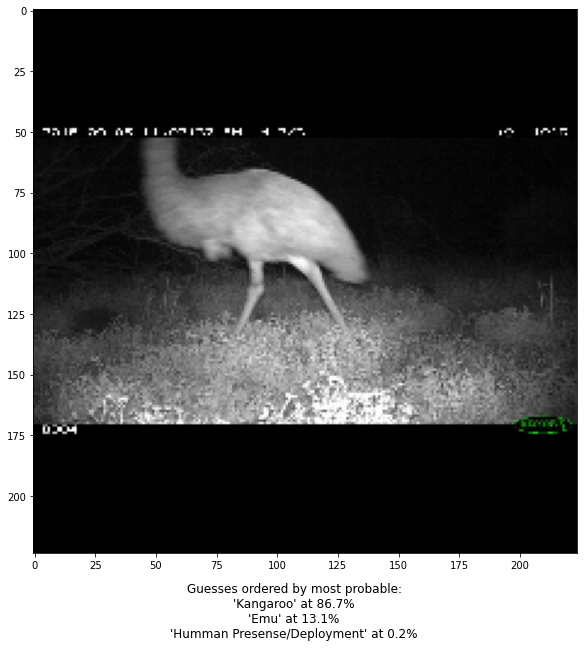

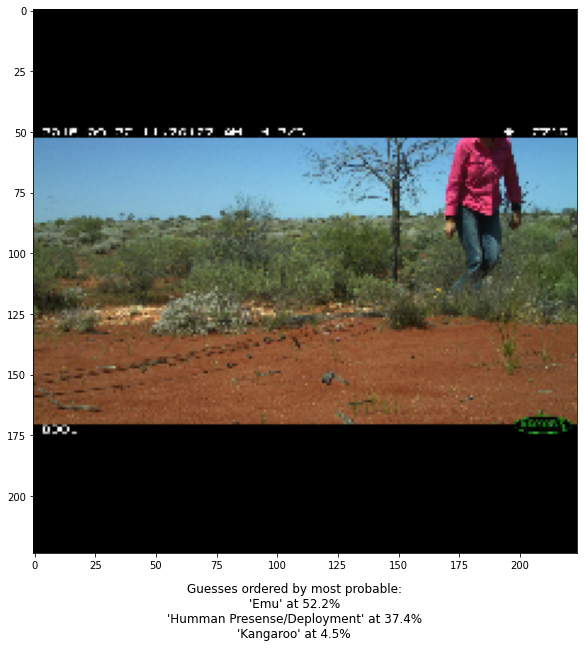

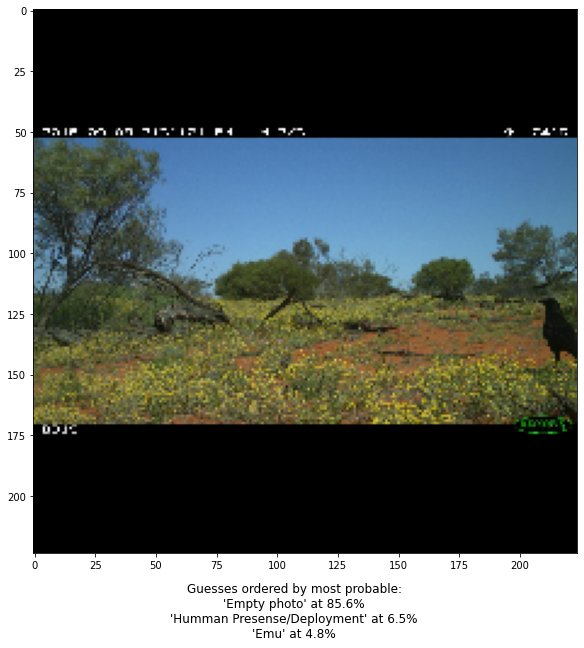

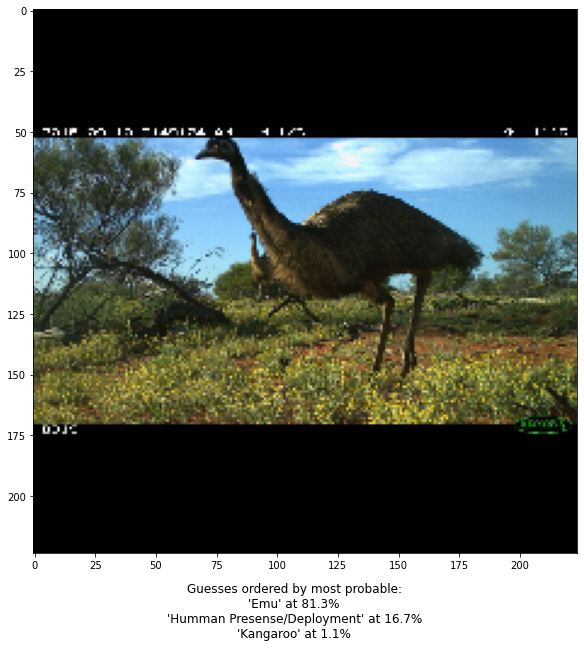

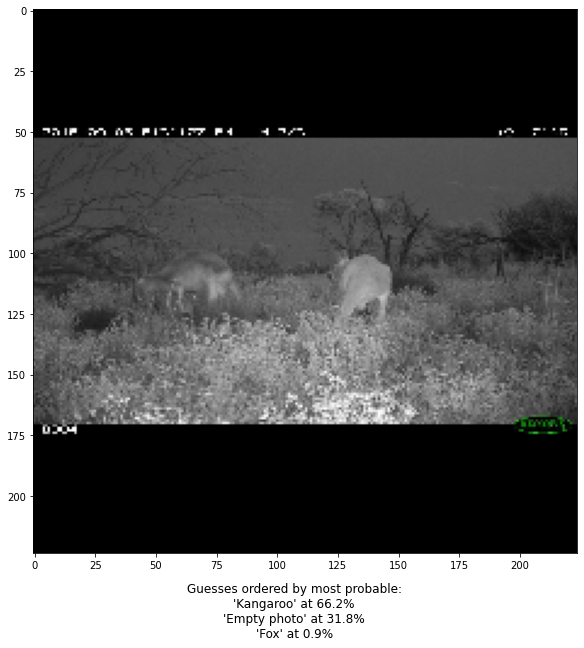

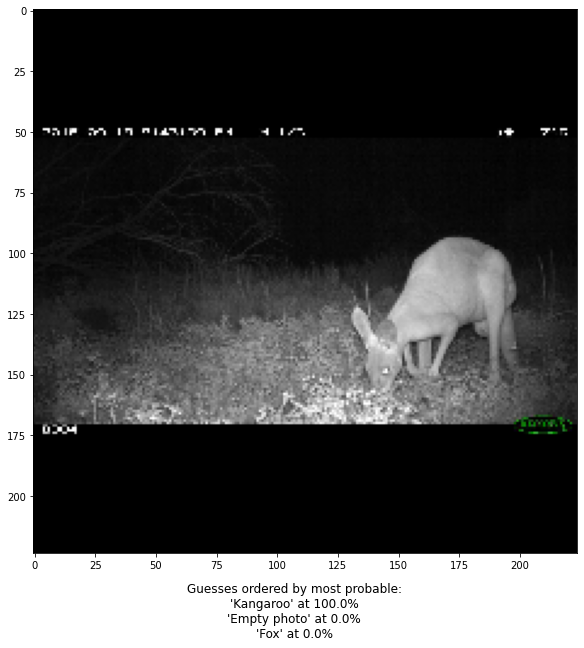

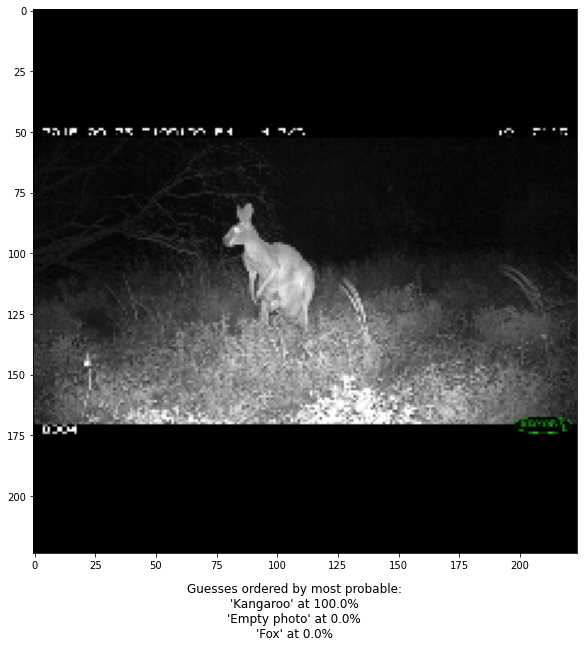

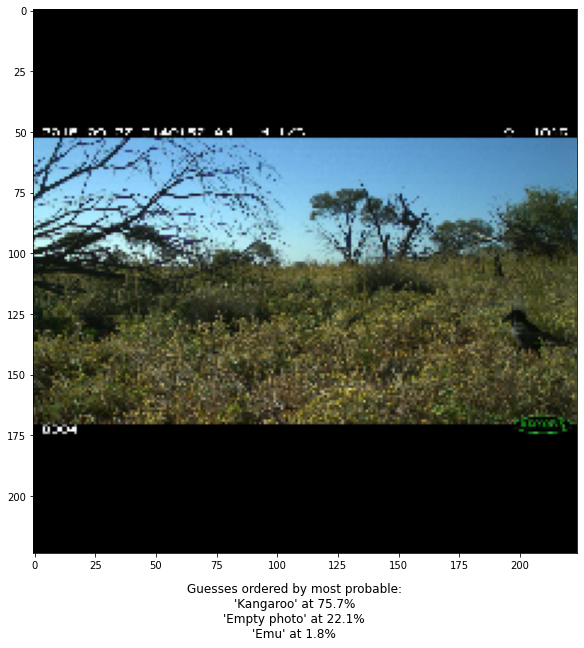

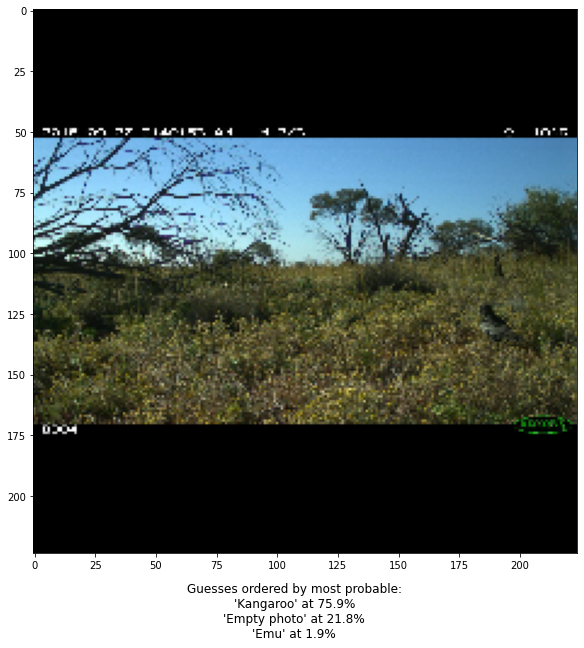

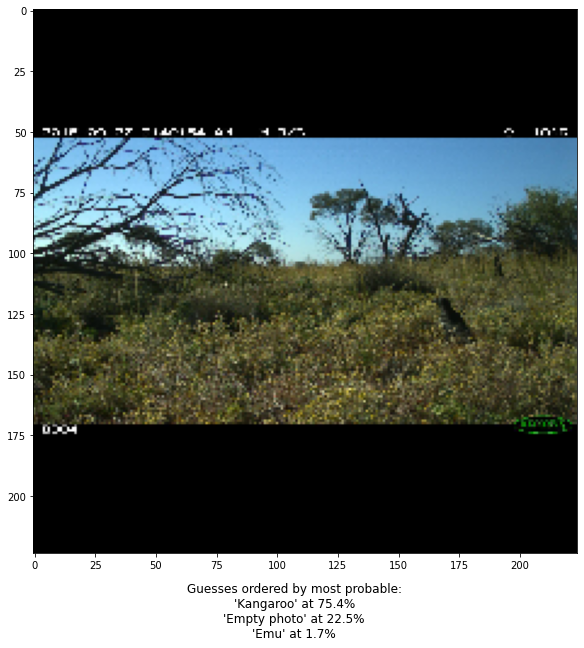

In [7]:
predictions_prob = model.predict(unlabelled_test_images)

for i in range(len(unlabelled_test_images)):    
    sorted_prob = np.sort(predictions_prob[i])
    max_pred = sorted_prob[len(sorted_prob) - 1]
    # find the index in the unsorted array, as that maps to an index in `class_mappings`
    max_pred_index = np.where(predictions_prob[i] == max_pred)[0][0]
    
    second_max_pred = sorted_prob[len(sorted_prob) - 2]
    second_max_pred_index = np.where(predictions_prob[i] == second_max_pred)[0][0]
    
    third_max_pred = sorted_prob[len(sorted_prob) - 3]
    third_max_pred_index = np.where(predictions_prob[i] == third_max_pred)[0][0]
    
    pred_str = "Guesses ordered by most probable: "
    pred_str += "\n'{}' at {}% ".format(class_mappings[max_pred_index], np.around(float(max_pred * 100), 1))
    pred_str += "\n'{}' at {}% ".format(class_mappings[second_max_pred_index], np.around(float(second_max_pred * 100), 1))
    pred_str += "\n'{}' at {}% ".format(class_mappings[third_max_pred_index], np.around(float(third_max_pred * 100), 1))
    
    displayImage(cv2.cvtColor(unlabelled_test_images[i], cv2.COLOR_BGR2RGB), pred_str)

## Free up the GPU's memory

In [8]:
cuda.select_device(0)
cuda.close()